The model takes parameters as input and predicts the meshed field representing the solidification morphology. We used a convolutional neural network since the output is structurally similar to an image. The network includes a latent representation formed by three fully connected layers with ReLU activations to capture nonlinear dependencies between parameters. This is followed by five ConvTranspose2d layers with ReLU activations to progressively upsample the latent tensor and reconstruct the 250×250 field. A final Sigmoid activation is used to constrain the output between 0 and 1.


In [ ]:
# Cell 0 - Import Libraries

# Basic
import numpy as np
import matplotlib.pyplot as plt

# PyTorch
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


In [ ]:
# Cell 1

# Load the new 250x250 data
X_train = np.load('X_train.npy')
Y_train = np.load('Y_train.npy')
X_test = np.load('X_test.npy')
Y_test = np.load('Y_test.npy')

print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)


X_train shape: (200, 5)
Y_train shape: (200, 250, 250)
X_test shape: (51, 5)
Y_test shape: (51, 250, 250)


In [ ]:
# Cell 2
class DendriteDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.Y[idx].unsqueeze(0) 
        return x, y

# Instantiate datasets
train_dataset = DendriteDataset(X_train, Y_train)
test_dataset = DendriteDataset(X_test, Y_test)


In [ ]:
# Cell 3

# Network Architecture

class DendriteCNN(nn.Module):
    def __init__(self):
        super(DendriteCNN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(5, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 64, kernel_size=4, stride=2, padding=1),  # 8x8 → 16x16
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # 16x16 → 32x32
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),  # 32x32 → 64x64
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, kernel_size=4, stride=2, padding=1),   # 64x64 → 128x128
            nn.ReLU(),
            nn.ConvTranspose2d(8, 1, kernel_size=4, stride=2, padding=1),    # 128x128 → 256x256
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, 16, 8, 8)  
        x = self.decoder(x)
        x = x[:, :, :250, :250]  
        return x


In [ ]:
# Cell 4

# training the network

from torch.utils.data import DataLoader

# Loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)  # Reduce batch size
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Model, loss, optimizer
model = DendriteCNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

n_epochs = 500

# Training loop
for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)  
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {running_loss/len(train_loader):.5f}")


Epoch [1/500], Loss: 0.21180
Epoch [2/500], Loss: 0.16854
Epoch [3/500], Loss: 0.13047
Epoch [4/500], Loss: 0.12367
Epoch [5/500], Loss: 0.12468
Epoch [6/500], Loss: 0.12157
Epoch [7/500], Loss: 0.12072
Epoch [8/500], Loss: 0.12006
Epoch [9/500], Loss: 0.11715
Epoch [10/500], Loss: 0.12012
Epoch [11/500], Loss: 0.11865
Epoch [12/500], Loss: 0.11838
Epoch [13/500], Loss: 0.11714
Epoch [14/500], Loss: 0.11566
Epoch [15/500], Loss: 0.11495
Epoch [16/500], Loss: 0.11527
Epoch [17/500], Loss: 0.11544
Epoch [18/500], Loss: 0.11543
Epoch [19/500], Loss: 0.11431
Epoch [20/500], Loss: 0.11537
Epoch [21/500], Loss: 0.11374
Epoch [22/500], Loss: 0.11493
Epoch [23/500], Loss: 0.11714
Epoch [24/500], Loss: 0.11461
Epoch [25/500], Loss: 0.11062
Epoch [26/500], Loss: 0.11024
Epoch [27/500], Loss: 0.11029
Epoch [28/500], Loss: 0.10990
Epoch [29/500], Loss: 0.10385
Epoch [30/500], Loss: 0.11045
Epoch [31/500], Loss: 0.10413
Epoch [32/500], Loss: 0.10624
Epoch [33/500], Loss: 0.10610
Epoch [34/500], Los

In [ ]:
# Cell 5

# Getting the MSE

def evaluate_mse(model, loader, dataset_name="Dataset"):
    model.eval()
    total_loss = 0.0
    criterion = nn.MSELoss()
    with torch.no_grad():
        for inputs, targets in loader:
            inputs = inputs.to(device)
            targets = targets.to(device) 
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item() * inputs.size(0) 

    mse = total_loss / len(loader.dataset)
    print(f"{dataset_name} MSE: {mse:.6f}")
    return mse

# Evaluate on train and test sets
train_mse = evaluate_mse(model, train_loader, "Training")
test_mse = evaluate_mse(model, test_loader, "Testing")


Training MSE: 0.019276
Testing MSE: 0.034309


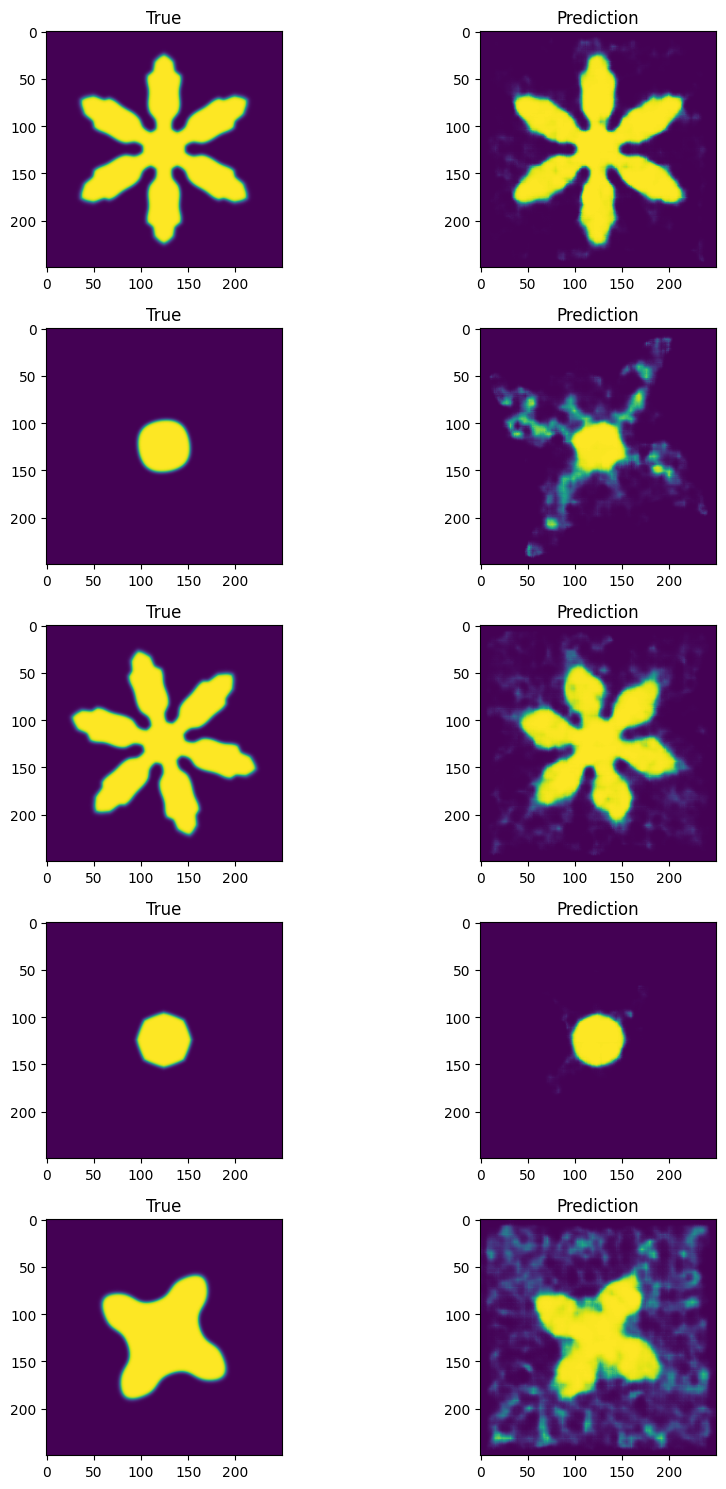

In [ ]:
# Cell 6

# Visualize the true final frames vs the predicted ones

model.eval()

def plot_predictions(model, dataset, n_samples=5):
    fig, axes = plt.subplots(n_samples, 2, figsize=(10, n_samples * 3))
    for i in range(n_samples):
        x, y = dataset[i]
        x = x.unsqueeze(0).to(device) 
        pred = model(x).detach().cpu().squeeze(0).squeeze(0)  
        
        axes[i, 0].imshow(y.squeeze(0).numpy(), cmap='viridis', vmin=0, vmax=1)
        axes[i, 0].set_title('True')
        axes[i, 1].imshow(pred.numpy(), cmap='viridis', vmin=0, vmax=1)
        axes[i, 1].set_title('Prediction')
    
    plt.tight_layout()
    plt.show()

# Call the function
plot_predictions(model, test_dataset)
